# AWBS - Project 2

author: Mateusz Domalewski

group: 2

index: 288761

In [1]:
### importing libraries
import polars as pl
import numpy as np
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
import graphviz
import networkx as nx
from collections import Counter
pl.Config.set_tbl_rows(100)
plt.style.use('bmh')

In [2]:
### importing data sources
E_COMMERCE = './data/E-commerce_Customer_Behavior_Sheet1.csv'

## satisfaction level of customers of e-commerce shop

In [3]:
ecommerce = pl.read_csv(E_COMMERCE)
## treat ids as strings
ecommerce.cast({"Customer ID" : pl.String})

ecommerce.describe()

shape: (9, 12)
┌────────────┬────────────┬────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ Customer   ┆ Gender ┆ Age       ┆ … ┆ Average   ┆ Discount  ┆ Days      ┆ Satisfact │
│ ---        ┆ ID         ┆ ---    ┆ ---       ┆   ┆ Rating    ┆ Applied   ┆ Since     ┆ ion Level │
│ str        ┆ ---        ┆ str    ┆ f64       ┆   ┆ ---       ┆ ---       ┆ Last      ┆ ---       │
│            ┆ f64        ┆        ┆           ┆   ┆ f64       ┆ f64       ┆ Purchase  ┆ str       │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆ ---       ┆           │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆ f64       ┆           │
╞════════════╪════════════╪════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 350.0      ┆ 350    ┆ 350.0     ┆ … ┆ 350.0     ┆ 350.0     ┆ 350.0     ┆ 348       │
│ null_count ┆ 0.0        ┆ 0      ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 2         │
│ mean       ┆ 275.5      ┆ null   ┆ 33.597143 ┆ … ┆ 4.019143  ┆ 0.5       ┆ 26.588571 ┆ null      │
│ std        ┆ 101.180532 ┆ null   ┆ 4.870882  ┆ … ┆ 0.580539  ┆ null      ┆ 13.440813 ┆ null      │
│ min        ┆ 101.0      ┆ Female ┆ 26.0      ┆ … ┆ 3.0       ┆ 0.0       ┆ 9.0       ┆ Neutral   │
│ 25%        ┆ 188.0      ┆ null   ┆ 30.0      ┆ … ┆ 3.5       ┆ null      ┆ 15.0      ┆ null      │
│ 50%        ┆ 276.0      ┆ null   ┆ 33.0      ┆ … ┆ 4.1       ┆ null      ┆ 23.0      ┆ null      │
│ 75%        ┆ 363.0      ┆ null   ┆ 37.0      ┆ … ┆ 4.5       ┆ null      ┆ 38.0      ┆ null      │
│ max        ┆ 450.0      ┆ Male   ┆ 43.0      ┆ … ┆ 4.9       ┆ 1.0       ┆ 63.0      ┆ Unsatisfi │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆ ed        │
└────────────┴────────────┴────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [4]:
## drop nulls for classes
ecommerce = ecommerce.drop_nulls()

In [5]:
feature_map = {
    "Customer ID" : "customer_id",
    "Gender" : "gender",
    "Age" : "age",
    "City" : "city",
    "Membership Type" : "membership",
    "Total Spend" : "total_spend",
    "Items Purchased" : "items_no",
    "Average Rating" : "rating_avg",
    "Discount Applied" : "discounted",
    "Satisfaction Level" : "satisfaction"
}
ecomm = ecommerce.rename(feature_map).cast({pl.String : pl.Categorical(ordering='lexical')})

In [6]:
ecomm_features = ecomm.select(pl.exclude("satisfaction"))
ecomm_targets = ecomm.select(pl.col("satisfaction")).to_series()

### Target Analysis

['Neutral' 'Satisfied' 'Unsatisfied']


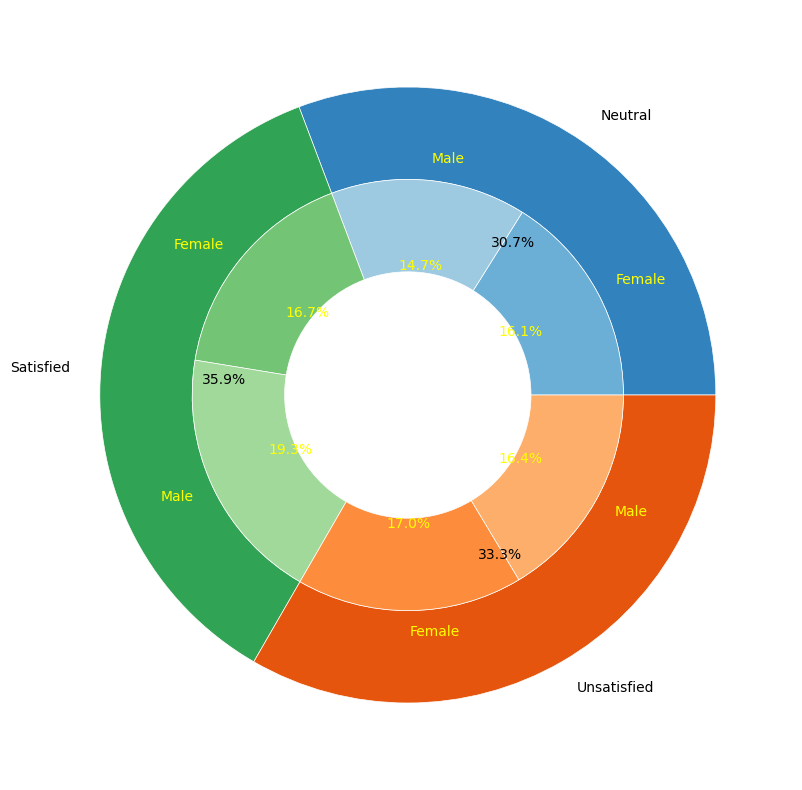

In [7]:
fig, ax = plt.subplots(figsize=[20,10], subplot_kw=dict(aspect="equal"))
size = 0.3
colors = plt.color_sequences['tab20c']

outer_colors = [colors[x] for x in [0, 8, 4]]

inner_colors = [colors[x] for x in [1,2, 9, 10, 5,6]]

target_counts = ecomm_targets.value_counts().sort("satisfaction")

gender_data = ecomm.group_by(pl.col("satisfaction"), pl.col("gender")).agg(pl.col("customer_id").count().alias("amount")).sort([pl.col("satisfaction"), pl.col("gender")])

types, counts = target_counts.to_numpy().transpose()

print(types)

genders, g_counts = gender_data.select(pl.col("gender"), pl.col("amount")).to_numpy().transpose()

ax.pie(counts, labels=types, radius=1, colors=outer_colors, autopct="%1.1f%%", wedgeprops=dict(width=size, edgecolor='w'), textprops=dict(color='black'))

ax.pie(g_counts, labels=genders, radius=1-size, colors=inner_colors, autopct="%1.1f%%", wedgeprops=dict(width=size, edgecolor='w'), textprops=dict(color='yellow'))

plt.show()

### Assessment of the dependence of customer satisfaction level on other parameters

In [8]:
## lets calculate the correlation
for col in ecomm_features.select(pl.col(pl.Categorical)):
    ecomm_features.hstack(col.to_dummies())
    
ecomm_features = ecomm_features.drop(pl.col(pl.Categorical))

[Text(0.5555555555555556, 0.875, 'x[2] <= 825.825\ngini = 0.665\nsamples = 348\nvalue = [107.0, 125.0, 116.0]'),
 Text(0.3333333333333333, 0.625, 'x[5] <= 0.5\ngini = 0.503\nsamples = 223\nvalue = [106.0, 1.0, 116.0]'),
 Text(0.4444444444444444, 0.75, 'True  '),
 Text(0.2222222222222222, 0.375, 'x[4] <= 4.35\ngini = 0.019\nsamples = 107\nvalue = [106.0, 1.0, 0.0]'),
 Text(0.1111111111111111, 0.125, 'gini = 0.0\nsamples = 106\nvalue = [106, 0, 0]'),
 Text(0.3333333333333333, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.4444444444444444, 0.375, 'gini = 0.0\nsamples = 116\nvalue = [0, 0, 116]'),
 Text(0.7777777777777778, 0.625, 'x[3] <= 12.5\ngini = 0.016\nsamples = 125\nvalue = [1, 124, 0]'),
 Text(0.6666666666666667, 0.75, '  False'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(0.8888888888888888, 0.375, 'gini = 0.0\nsamples = 124\nvalue = [0, 124, 0]')]

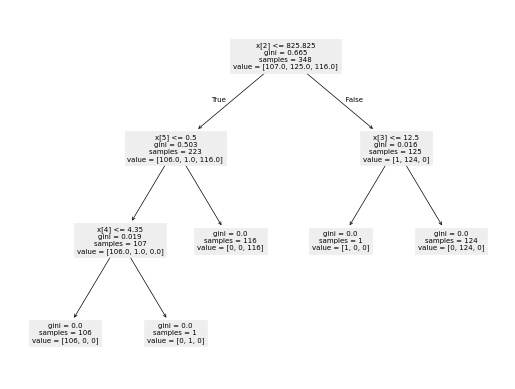

In [9]:
## decision tree time
tree_cf = tree.DecisionTreeClassifier()
tree_cf.fit(ecomm_features, ecomm_targets)

tree.plot_tree(tree_cf)

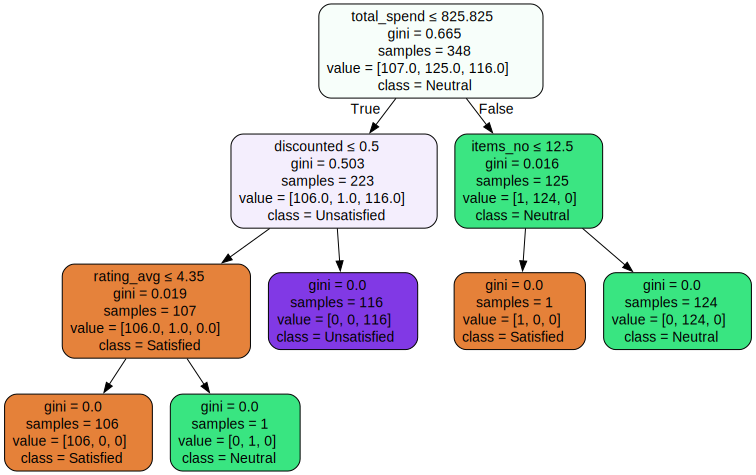

In [10]:
tree_data = tree.export_graphviz(tree_cf, 
                             feature_names=ecomm_features.columns, 
                             class_names=ecomm_targets.unique(),
                             filled=True, 
                             rounded=True,
                             special_characters=True)
graph = graphviz.Source(tree_data)  
graph

## Google merch shop

In [11]:
DATASET = './data/bq-results-20250515-133239-1747315972611.csv'

In [12]:
raw_df = pl.read_csv(DATASET)
raw_df.describe()

shape: (9, 11)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬─────────┬───────────┐
│ statistic  ┆ event_dat ┆ event_nam ┆ event_tim ┆ … ┆ traffic_s ┆ page_loca ┆ revenue ┆ engagemen │
│ ---        ┆ e         ┆ e         ┆ estamp    ┆   ┆ ource     ┆ tion      ┆ ---     ┆ t_time_ms │
│ str        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str     ┆ ec        │
│            ┆ f64       ┆ str       ┆ f64       ┆   ┆ str       ┆ str       ┆         ┆ ---       │
│            ┆           ┆           ┆           ┆   ┆           ┆           ┆         ┆ f64       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═════════╪═══════════╡
│ count      ┆ 87534.0   ┆ 87534     ┆ 87534.0   ┆ … ┆ 87534     ┆ 87534     ┆ 40      ┆ 45072.0   │
│ null_count ┆ 0.0       ┆ 0         ┆ 0.0       ┆ … ┆ 0         ┆ 0         ┆ 87494   ┆ 42462.0   │
│ mean       ┆ 2.0201e7  ┆ null      ┆ 1.6088e15 ┆ … ┆ null      ┆ null      ┆ null    ┆ 11551.687 │
│            ┆           ┆           ┆           ┆   ┆           ┆           ┆         ┆ 101       │
│ std        ┆ 0.809831  ┆ null      ┆ 7.3185e10 ┆ … ┆ null      ┆ null      ┆ null    ┆ 29950.814 │
│            ┆           ┆           ┆           ┆   ┆           ┆           ┆         ┆ 2         │
│ min        ┆ 2.0201223 ┆ add_payme ┆ 1.6087e15 ┆ … ┆ (data     ┆ http://sh ┆ 11      ┆ 1.0       │
│            ┆ e7        ┆ nt_info   ┆           ┆   ┆ deleted)  ┆ op.google ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ merchandi ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ses…      ┆         ┆           │
│ 25%        ┆ 2.0201223 ┆ null      ┆ 1.6087e15 ┆ … ┆ null      ┆ null      ┆ null    ┆ 1443.0    │
│            ┆ e7        ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ 50%        ┆ 2.0201224 ┆ null      ┆ 1.6088e15 ┆ … ┆ null      ┆ null      ┆ null    ┆ 5266.0    │
│            ┆ e7        ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ 75%        ┆ 2.0201224 ┆ null      ┆ 1.6089e15 ┆ … ┆ null      ┆ null      ┆ null    ┆ 12752.0   │
│            ┆ e7        ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ max        ┆ 2.0201225 ┆ view_sear ┆ 1.6089e15 ┆ … ┆ <Other>   ┆ https://w ┆ 99      ┆ 2.971499e │
│            ┆ e7        ┆ ch_result ┆           ┆   ┆           ┆ ww.google ┆         ┆ 6         │
│            ┆           ┆ s         ┆           ┆   ┆           ┆ merchandi ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ses…      ┆         ┆           │
└────────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴─────────┴───────────┘

In [13]:
data = raw_df.with_columns(
    pl.col("event_date").cast(pl.String).str.to_date(format="%Y%m%d"),
    pl.col("event_name").cast(pl.Categorical),
    pl.col("event_timestamp").cast(pl.Datetime),
    pl.col("user_pseudo_id").cast(pl.String),
    pl.col("country").cast(pl.Categorical),
    pl.col("device_category").cast(pl.Categorical),
    pl.col("revenue").cast(pl.UInt16).fill_null(0),
    pl.col("engagement_time_msec").cast(pl.UInt64).fill_null(0)
)
data.head()

shape: (5, 10)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬─────────┬───────────┐
│ event_date ┆ event_nam ┆ event_tim ┆ user_pseu ┆ … ┆ traffic_s ┆ page_loca ┆ revenue ┆ engagemen │
│ ---        ┆ e         ┆ estamp    ┆ do_id     ┆   ┆ ource     ┆ tion      ┆ ---     ┆ t_time_ms │
│ date       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ u16     ┆ ec        │
│            ┆ cat       ┆ datetime[ ┆ str       ┆   ┆ str       ┆ str       ┆         ┆ ---       │
│            ┆           ┆ μs]       ┆           ┆   ┆           ┆           ┆         ┆ u64       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═════════╪═══════════╡
│ 2020-12-25 ┆ page_view ┆ 2020-12-2 ┆ 1002118.4 ┆ … ┆ (direct)  ┆ https://s ┆ 0       ┆ 0         │
│            ┆           ┆ 5 18:30:0 ┆ 468776061 ┆   ┆           ┆ hop.googl ┆         ┆           │
│            ┆           ┆ 4.450512  ┆           ┆   ┆           ┆ emerchand ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ise…      ┆         ┆           │
│ 2020-12-25 ┆ first_vis ┆ 2020-12-2 ┆ 1002118.4 ┆ … ┆ (direct)  ┆ https://s ┆ 0       ┆ 0         │
│            ┆ it        ┆ 5 18:30:0 ┆ 468776061 ┆   ┆           ┆ hop.googl ┆         ┆           │
│            ┆           ┆ 4.450512  ┆           ┆   ┆           ┆ emerchand ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ise…      ┆         ┆           │
│ 2020-12-25 ┆ session_s ┆ 2020-12-2 ┆ 1002118.4 ┆ … ┆ (direct)  ┆ https://s ┆ 0       ┆ 0         │
│            ┆ tart      ┆ 5 18:30:0 ┆ 468776061 ┆   ┆           ┆ hop.googl ┆         ┆           │
│            ┆           ┆ 4.450512  ┆           ┆   ┆           ┆ emerchand ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ise…      ┆         ┆           │
│ 2020-12-25 ┆ scroll    ┆ 2020-12-2 ┆ 1019549.7 ┆ … ┆ (organic) ┆ https://g ┆ 0       ┆ 554       │
│            ┆           ┆ 5 21:51:5 ┆ 191616026 ┆   ┆           ┆ ooglemerc ┆         ┆           │
│            ┆           ┆ 5.659562  ┆           ┆   ┆           ┆ handisest ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ore…      ┆         ┆           │
│ 2020-12-25 ┆ user_enga ┆ 2020-12-2 ┆ 1019549.7 ┆ … ┆ (organic) ┆ https://g ┆ 0       ┆ 2755      │
│            ┆ gement    ┆ 5 21:51:5 ┆ 191616026 ┆   ┆           ┆ ooglemerc ┆         ┆           │
│            ┆           ┆ 5.659562  ┆           ┆   ┆           ┆ handisest ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ore…      ┆         ┆           │
└────────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴─────────┴───────────┘

In [14]:
### check unique events
data.group_by("event_name").agg(
    pl.col("event_name").count().alias("counts"),
    pl.col("user_pseudo_id").unique().count().alias("unique_users"),
    pl.col("revenue").mean(),
    pl.col("engagement_time_msec").mean()
).sort("counts", descending=True)
#.transpose(column_names="event_name", include_header=True)

shape: (16, 5)
┌─────────────────────┬────────┬──────────────┬───────────┬──────────────────────┐
│ event_name          ┆ counts ┆ unique_users ┆ revenue   ┆ engagement_time_msec │
│ ---                 ┆ ---    ┆ ---          ┆ ---       ┆ ---                  │
│ cat                 ┆ u32    ┆ u32          ┆ f64       ┆ f64                  │
╞═════════════════════╪════════╪══════════════╪═══════════╪══════════════════════╡
│ page_view           ┆ 24669  ┆ 7861         ┆ 0.0       ┆ 0.0                  │
│ user_engagement     ┆ 20242  ┆ 5998         ┆ 0.0       ┆ 13609.640747         │
│ scroll              ┆ 9873   ┆ 3302         ┆ 0.0       ┆ 13897.413046         │
│ session_start       ┆ 8807   ┆ 7909         ┆ 0.0       ┆ 0.0                  │
│ view_item           ┆ 7660   ┆ 1447         ┆ 0.0       ┆ 12221.074674         │
│ first_visit         ┆ 6975   ┆ 6974         ┆ 0.0       ┆ 0.0                  │
│ view_promotion      ┆ 3757   ┆ 2421         ┆ 0.0       ┆ 929.307958           │
│ add_to_cart         ┆ 2061   ┆ 356          ┆ 0.0       ┆ 3075.684134          │
│ select_item         ┆ 985    ┆ 431          ┆ 0.0       ┆ 4150.831472          │
│ begin_checkout      ┆ 979    ┆ 162          ┆ 0.0       ┆ 98.300306            │
│ view_search_results ┆ 586    ┆ 378          ┆ 0.0       ┆ 192.293515           │
│ add_shipping_info   ┆ 328    ┆ 162          ┆ 0.0       ┆ 1.545732             │
│ add_payment_info    ┆ 249    ┆ 123          ┆ 0.0       ┆ 7.004016             │
│ select_promotion    ┆ 233    ┆ 197          ┆ 0.0       ┆ 2.626609             │
│ purchase            ┆ 107    ┆ 91           ┆ 22.327103 ┆ 5.953271             │
│ click               ┆ 23     ┆ 20           ┆ 0.0       ┆ 9448.608696          │
└─────────────────────┴────────┴──────────────┴───────────┴──────────────────────┘

### user engagement levels

In [15]:
### plot by half hour
engagement = data.group_by(pl.col("event_timestamp").dt.round("30m")).agg(
    #pl.col("event_timestamp").dt.round("30m").alias("time"),
    pl.col("engagement_time_msec").sum() / 1_000, 
    pl.col("event_name").count().alias("events"),
    pl.col("revenue").sum().alias("total_revenue"),
).sort("event_timestamp")
time, eng, events, revenue = engagement.cast({"event_timestamp" : pl.String}).to_numpy().transpose()

time = time.astype(np.datetime64)

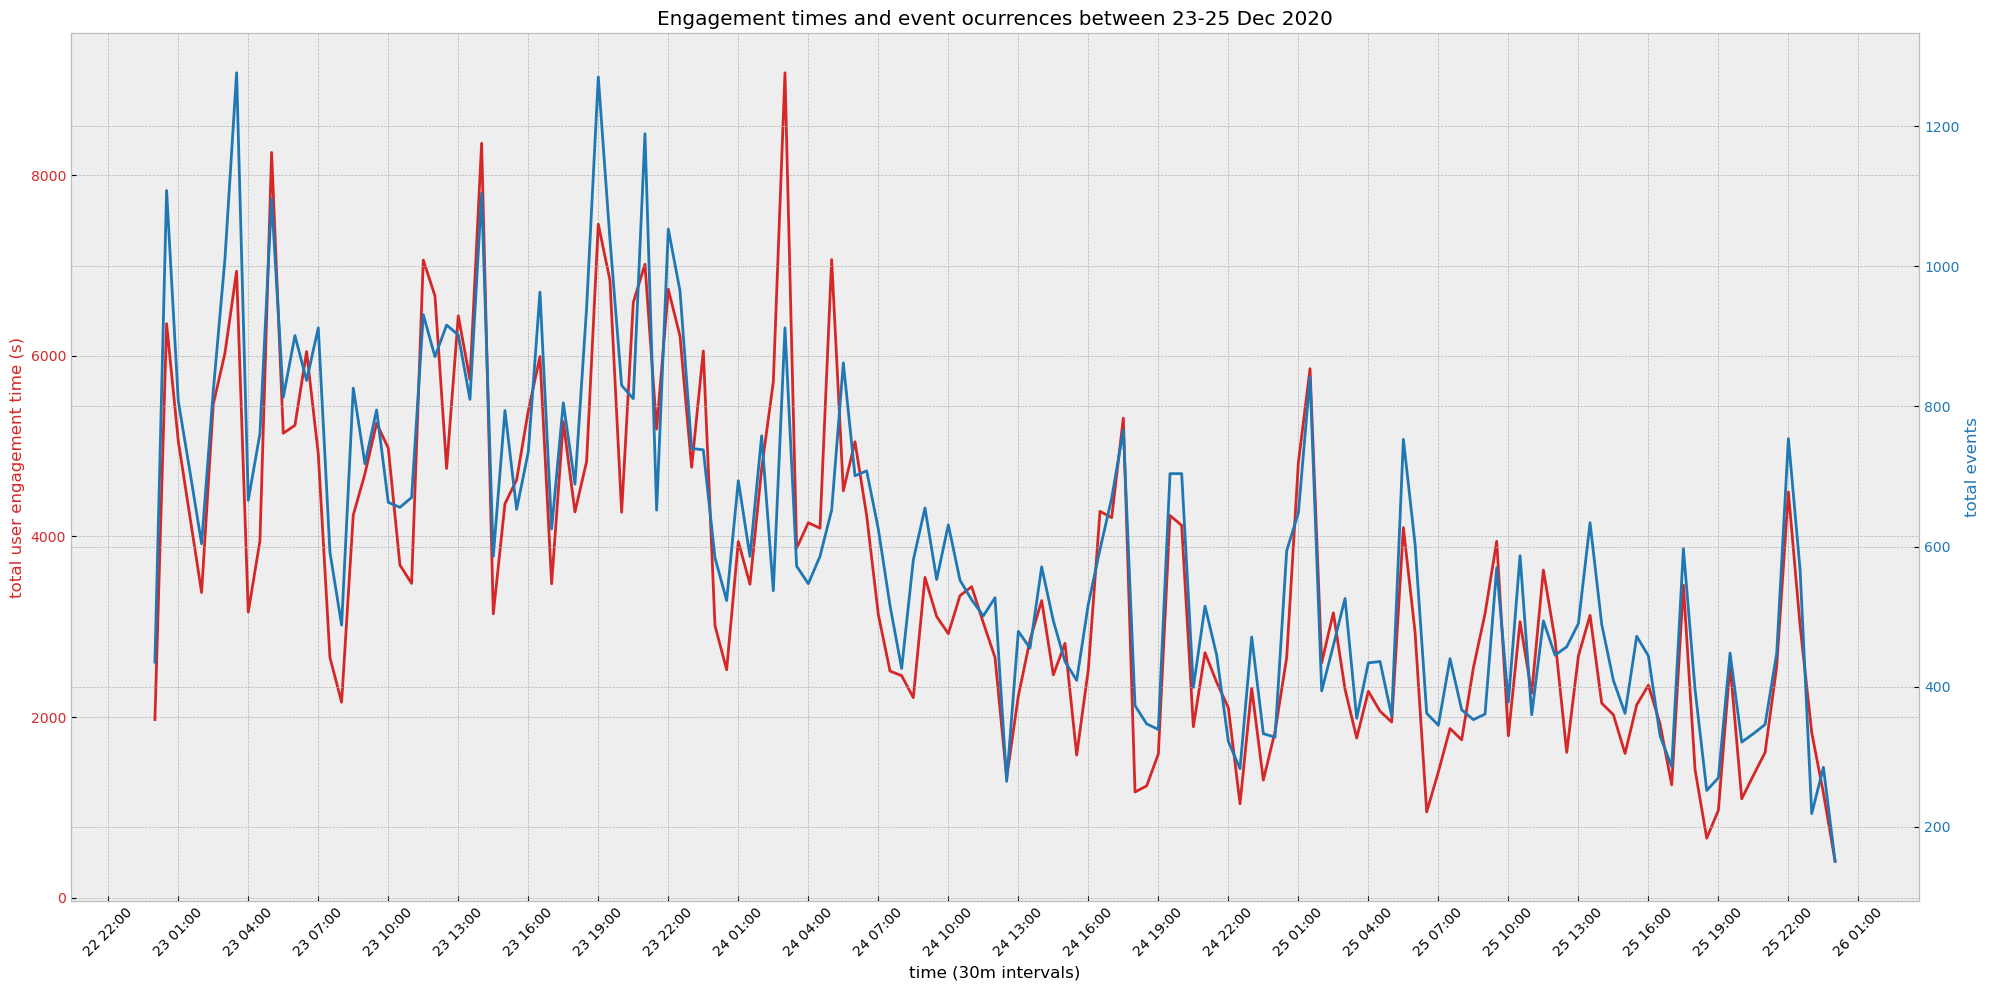

In [16]:
fig, ax1 = plt.subplots(figsize=[20,10])

plt.title("Engagement times and event ocurrences between 23-25 Dec 2020")

color = 'tab:red'
ax1.set_xlabel('time (30m intervals)')

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
plt.xticks(rotation=45)

ax1.set_ylabel('total user engagement time (s)', color=color)
ax1.plot(time, eng, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total events', color=color)  # we already handled the x-label with ax1
ax2.plot(time, events, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

> Based on the graph i decided that hours between 01:00 to 04:00 provide a lot of interesting datapoints

In [17]:
engagement = engagement.filter(pl.col("event_timestamp").dt.hour().is_between(1, 4))
time, eng, events, revenue = engagement.cast({"event_timestamp" : pl.String}).to_numpy().transpose()

time = time.astype(np.datetime64)

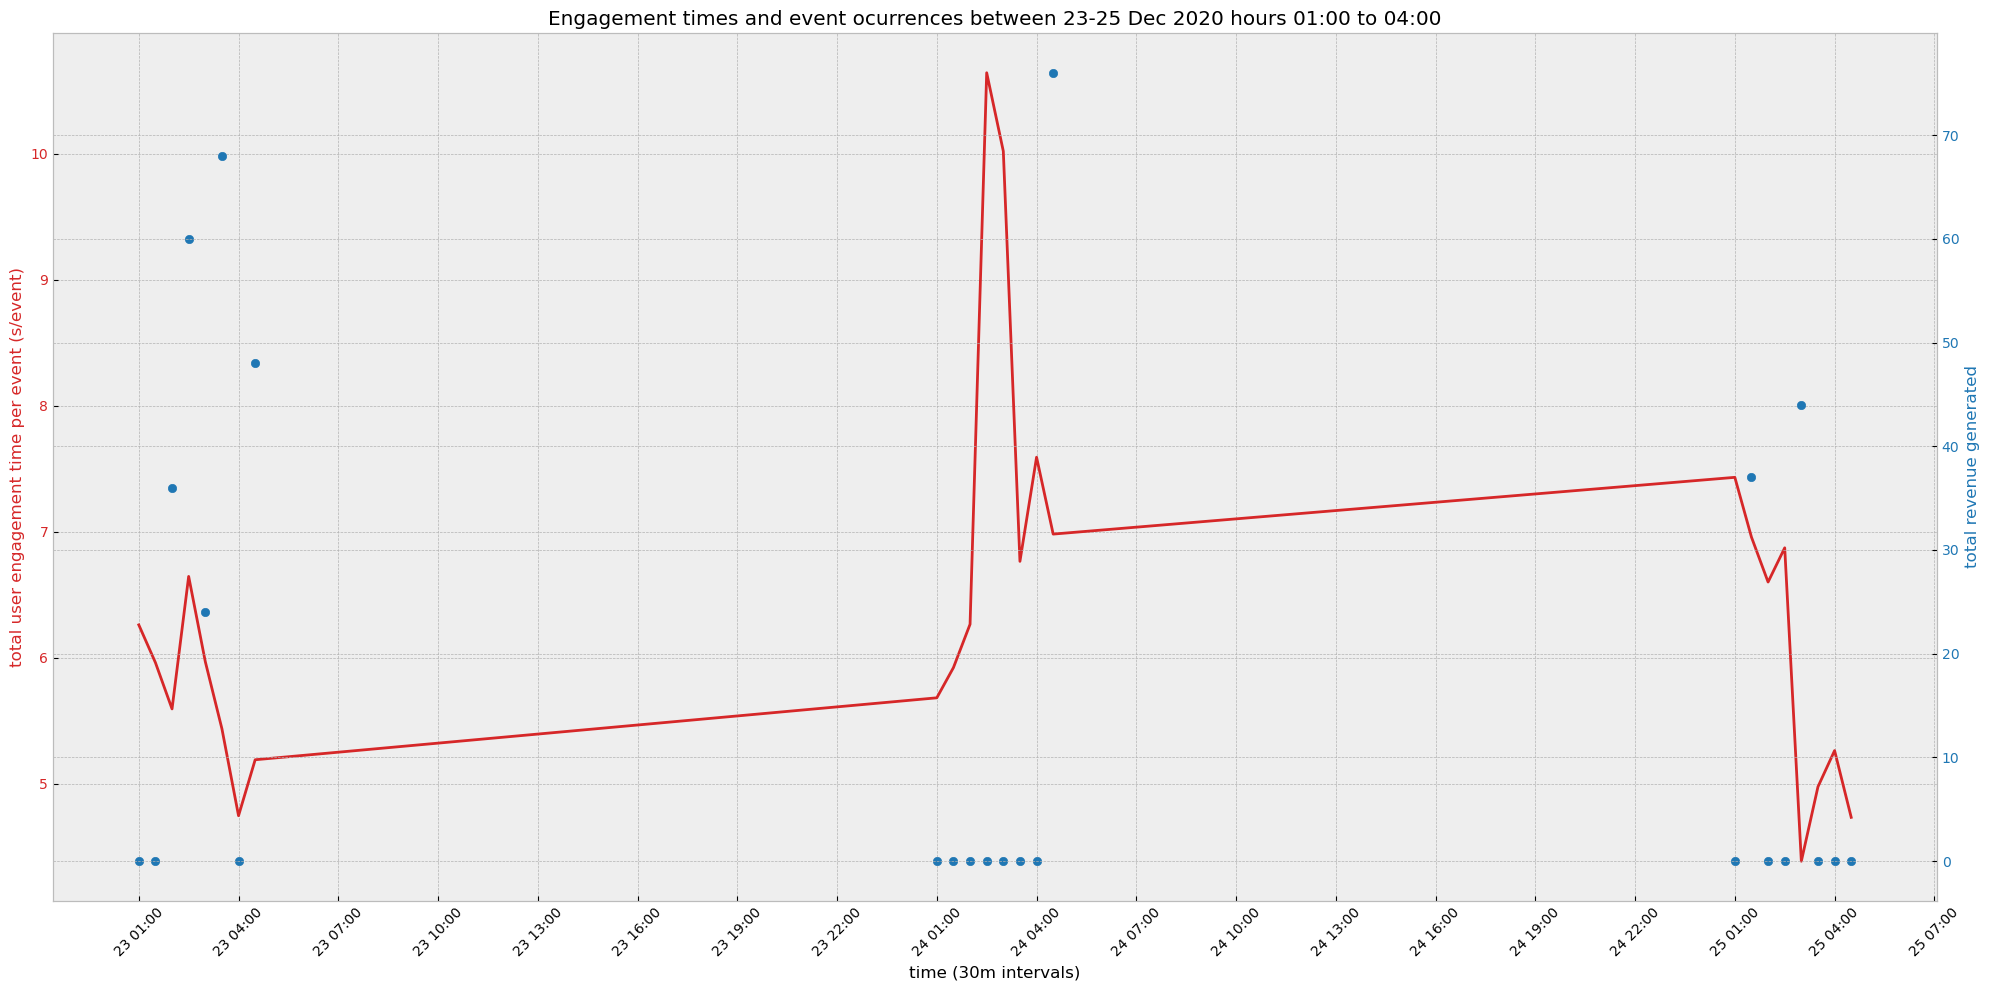

In [18]:
fig, ax1 = plt.subplots(figsize=[20,10])

plt.title("Engagement times and event ocurrences between 23-25 Dec 2020 hours 01:00 to 04:00")

color = 'tab:red'
ax1.set_xlabel('time (30m intervals)')

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
plt.xticks(rotation=45)

ax1.set_ylabel('total user engagement time per event (s/event)', color=color)
ax1.plot(time, eng / events, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total revenue generated', color=color)  # we already handled the x-label with ax1
ax2.scatter(time, revenue, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

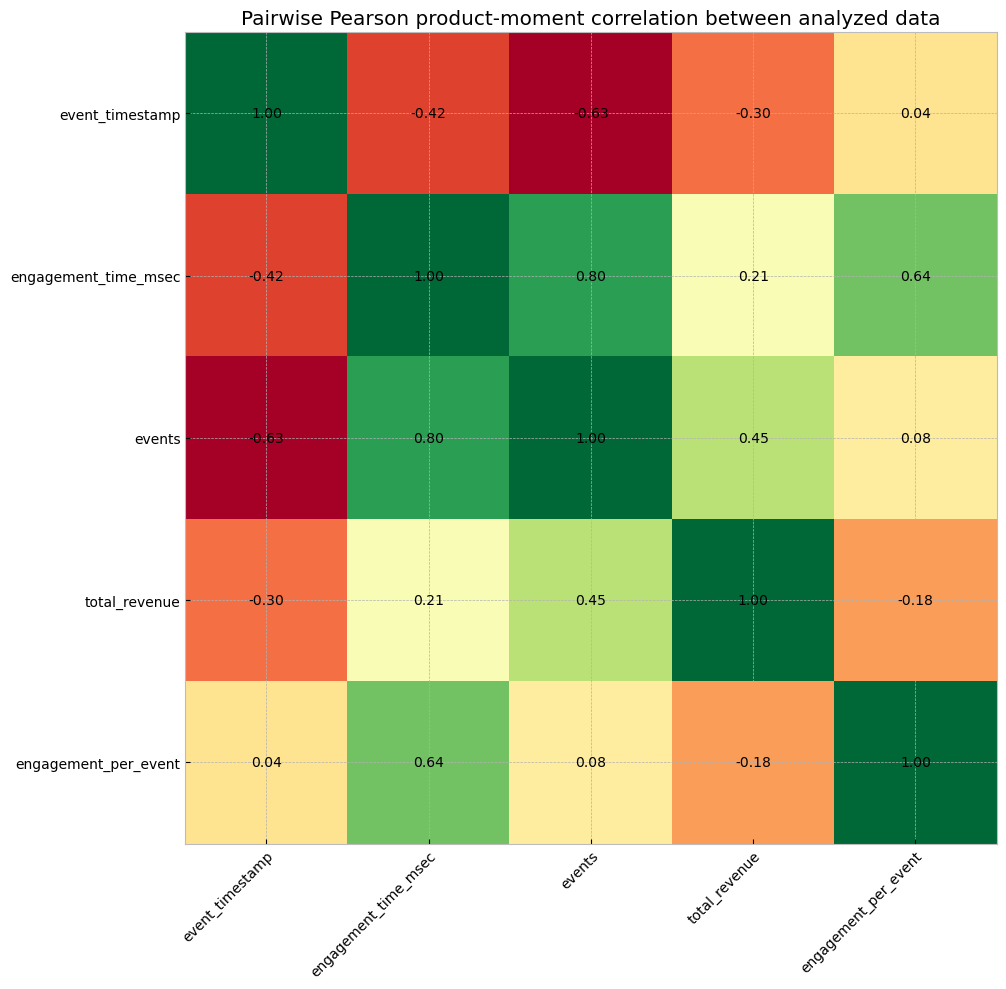

In [19]:
### check if there exists a corelation between time per event and revenue
fig, ax = plt.subplots(figsize=[20,10])

correlations = engagement.with_columns((pl.col("engagement_time_msec") / pl.col("events")).alias("engagement_per_event"))

corr_data = correlations.corr().to_numpy()

ax.imshow(corr_data, cmap="RdYlGn")
# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(correlations.columns)), labels=correlations.columns,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(correlations.columns)), labels=correlations.columns)

# Loop over data dimensions and create text annotations.
for i in range(len(correlations.columns)):
    for j in range(len(correlations.columns)):
        text = ax.text(j, i, f"{corr_data[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax.set_title("Pairwise Pearson product-moment correlation between analyzed data")
fig.tight_layout()

plt.show()

> as can be see engagement time strongly correlates with total events which was expected
> In this period it also negatively correlates with time which can be attributed to the holiday period
> there seems to be no distinguishable correlation to total generated revenue

### Customer behavior model graph

In [20]:
data.head()

shape: (5, 10)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬─────────┬───────────┐
│ event_date ┆ event_nam ┆ event_tim ┆ user_pseu ┆ … ┆ traffic_s ┆ page_loca ┆ revenue ┆ engagemen │
│ ---        ┆ e         ┆ estamp    ┆ do_id     ┆   ┆ ource     ┆ tion      ┆ ---     ┆ t_time_ms │
│ date       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ u16     ┆ ec        │
│            ┆ cat       ┆ datetime[ ┆ str       ┆   ┆ str       ┆ str       ┆         ┆ ---       │
│            ┆           ┆ μs]       ┆           ┆   ┆           ┆           ┆         ┆ u64       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═════════╪═══════════╡
│ 2020-12-25 ┆ page_view ┆ 2020-12-2 ┆ 1002118.4 ┆ … ┆ (direct)  ┆ https://s ┆ 0       ┆ 0         │
│            ┆           ┆ 5 18:30:0 ┆ 468776061 ┆   ┆           ┆ hop.googl ┆         ┆           │
│            ┆           ┆ 4.450512  ┆           ┆   ┆           ┆ emerchand ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ise…      ┆         ┆           │
│ 2020-12-25 ┆ first_vis ┆ 2020-12-2 ┆ 1002118.4 ┆ … ┆ (direct)  ┆ https://s ┆ 0       ┆ 0         │
│            ┆ it        ┆ 5 18:30:0 ┆ 468776061 ┆   ┆           ┆ hop.googl ┆         ┆           │
│            ┆           ┆ 4.450512  ┆           ┆   ┆           ┆ emerchand ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ise…      ┆         ┆           │
│ 2020-12-25 ┆ session_s ┆ 2020-12-2 ┆ 1002118.4 ┆ … ┆ (direct)  ┆ https://s ┆ 0       ┆ 0         │
│            ┆ tart      ┆ 5 18:30:0 ┆ 468776061 ┆   ┆           ┆ hop.googl ┆         ┆           │
│            ┆           ┆ 4.450512  ┆           ┆   ┆           ┆ emerchand ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ise…      ┆         ┆           │
│ 2020-12-25 ┆ scroll    ┆ 2020-12-2 ┆ 1019549.7 ┆ … ┆ (organic) ┆ https://g ┆ 0       ┆ 554       │
│            ┆           ┆ 5 21:51:5 ┆ 191616026 ┆   ┆           ┆ ooglemerc ┆         ┆           │
│            ┆           ┆ 5.659562  ┆           ┆   ┆           ┆ handisest ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ore…      ┆         ┆           │
│ 2020-12-25 ┆ user_enga ┆ 2020-12-2 ┆ 1019549.7 ┆ … ┆ (organic) ┆ https://g ┆ 0       ┆ 2755      │
│            ┆ gement    ┆ 5 21:51:5 ┆ 191616026 ┆   ┆           ┆ ooglemerc ┆         ┆           │
│            ┆           ┆ 5.659562  ┆           ┆   ┆           ┆ handisest ┆         ┆           │
│            ┆           ┆           ┆           ┆   ┆           ┆ ore…      ┆         ┆           │
└────────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴─────────┴───────────┘

In [21]:
### get customer sessions data
shop_page_prefix="https://shop.googlemerchandisestore.com/"

customer_sessions = data.sort("event_timestamp").group_by((pl.col("user_pseudo_id"), pl.col("traffic_source")), maintain_order=True).agg(
    pl.col("event_name"), 
    pl.col("page_location").str.strip_prefix(shop_page_prefix).str.replace_all('\\+', ' ').str.replace_all("(google|Google)", ''), 
    pl.int_range(0, pl.col("event_name").count()).alias("event_id"),
    pl.col("engagement_time_msec").sum(), 
    pl.col("revenue").max()
)

customer_sessions.head()

shape: (5, 7)
┌──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┬─────────┐
│ user_pseudo_ ┆ traffic_sour ┆ event_name   ┆ page_locatio ┆ event_id     ┆ engagement_ ┆ revenue │
│ id           ┆ ce           ┆ ---          ┆ n            ┆ ---          ┆ time_msec   ┆ ---     │
│ ---          ┆ ---          ┆ list[cat]    ┆ ---          ┆ list[i64]    ┆ ---         ┆ u16     │
│ str          ┆ str          ┆              ┆ list[str]    ┆              ┆ u64         ┆         │
╞══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╪═════════╡
│ 53552487.314 ┆ (data        ┆ ["user_engag ┆ [" redesign/ ┆ [0, 1, … 28] ┆ 24362       ┆ 0       │
│ 18546        ┆ deleted)     ┆ ement",      ┆ bags/backpac ┆              ┆             ┆         │
│              ┆              ┆ "page_view…  ┆ ks/hom…      ┆              ┆             ┆         │
│ 20724158.227 ┆ (organic)    ┆ ["page_view" ┆ [" Redesign/ ┆ [0, 1, 2]    ┆ 0           ┆ 0       │
│ 944598       ┆              ┆ , "first_vis ┆ Apparel/     ┆              ┆             ┆         │
│              ┆              ┆ it", "…      ┆ Dino Game…   ┆              ┆             ┆         │
│ 8219476.4232 ┆ (data        ┆ ["user_engag ┆ [" Redesign/ ┆ [0, 1, … 6]  ┆ 35458       ┆ 0       │
│ 23402        ┆ deleted)     ┆ ement",      ┆ Super G      ┆              ┆             ┆         │
│              ┆              ┆ "page_view…  ┆ Unisex Jog…  ┆              ┆             ┆         │
│ 86089027.432 ┆ (data        ┆ ["page_view" ┆ [" Redesign/ ┆ [0, 1]       ┆ 0           ┆ 0       │
│ 87711        ┆ deleted)     ┆ , "session_s ┆ Drinkware/   ┆              ┆             ┆         │
│              ┆              ┆ tart"]       ┆ Woodtop…     ┆              ┆             ┆         │
│ 7069211.7963 ┆ (organic)    ┆ ["session_st ┆ ["https://ww ┆ [0, 1, … 4]  ┆ 11669       ┆ 0       │
│ 81787        ┆              ┆ art", "page_ ┆ w.merchandis ┆              ┆             ┆         │
│              ┆              ┆ view",…      ┆ estore…      ┆              ┆             ┆         │
└──────────────┴──────────────┴──────────────┴──────────────┴──────────────┴─────────────┴─────────┘

In [22]:
## get paying customer sessions
paying_sessions = customer_sessions.filter(pl.col("revenue").gt(0))
paying_sessions

shape: (34, 7)
┌──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┬─────────┐
│ user_pseudo_ ┆ traffic_sour ┆ event_name   ┆ page_locatio ┆ event_id     ┆ engagement_ ┆ revenue │
│ id           ┆ ce           ┆ ---          ┆ n            ┆ ---          ┆ time_msec   ┆ ---     │
│ ---          ┆ ---          ┆ list[cat]    ┆ ---          ┆ list[i64]    ┆ ---         ┆ u16     │
│ str          ┆ str          ┆              ┆ list[str]    ┆              ┆ u64         ┆         │
╞══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╪═════════╡
│ 7450806.9278 ┆ (data        ┆ ["session_st ┆ ["", "", …   ┆ [0, 1, … 61] ┆ 497911      ┆ 36      │
│ 13993        ┆ deleted)     ┆ art", "page_ ┆ "ordercomple ┆              ┆             ┆         │
│              ┆              ┆ view",…      ┆ ted.htm…     ┆              ┆             ┆         │
│ 88356029.858 ┆ (direct)     ┆ ["first_visi ┆ ["https://me ┆ [0, 1, … 55] ┆ 407310      ┆ 60      │
│ 46578        ┆              ┆ t", "session ┆ rchandisesto ┆              ┆             ┆         │
│              ┆              ┆ _start…      ┆ re.com…      ┆              ┆             ┆         │
│ 36423903.076 ┆ (direct)     ┆ ["session_st ┆ ["", "", …   ┆ [0, 1, …     ┆ 1089151     ┆ 44      │
│ 64828        ┆              ┆ art", "page_ ┆ "myaccount.h ┆ 146]         ┆             ┆         │
│              ┆              ┆ view",…      ┆ tml"]        ┆              ┆             ┆         │
│ 8848313.6690 ┆ (referral)   ┆ ["page_view" ┆ ["", "", …   ┆ [0, 1, …     ┆ 743620      ┆ 24      │
│ 70125        ┆              ┆ , "session_s ┆ "ordercomple ┆ 135]         ┆             ┆         │
│              ┆              ┆ tart",…      ┆ ted.htm…     ┆              ┆             ┆         │
│ 5590716.6791 ┆ <Other>      ┆ ["session_st ┆ ["", "", … " ┆ [0, 1, … 47] ┆ 271945      ┆ 24      │
│ 91002        ┆              ┆ art", "page_ ┆ Redesign/Lif ┆              ┆             ┆         │
│              ┆              ┆ view",…      ┆ estyl…       ┆              ┆             ┆         │
│ 89509806.870 ┆ (referral)   ┆ ["page_view" ┆ ["", "", …   ┆ [0, 1, … 77] ┆ 425430      ┆ 48      │
│ 21178        ┆              ┆ , "session_s ┆ "myaccount.h ┆              ┆             ┆         │
│              ┆              ┆ tart",…      ┆ tml"]        ┆              ┆             ┆         │
│ 42140555.782 ┆ (direct)     ┆ ["first_visi ┆ ["https://me ┆ [0, 1, … 69] ┆ 286539      ┆ 35      │
│ 900594       ┆              ┆ t", "session ┆ rchandisesto ┆              ┆             ┆         │
│              ┆              ┆ _start…      ┆ re.com…      ┆              ┆             ┆         │
│ 2418457.6264 ┆ <Other>      ┆ ["session_st ┆ ["", "", … " ┆ [0, 1, …     ┆ 1387720     ┆ 88      │
│ 80545        ┆              ┆ art", "page_ ┆ Redesign/Bag ┆ 183]         ┆             ┆         │
│              ┆              ┆ view",…      ┆ s/Sup…       ┆              ┆             ┆         │
│ 31844096.549 ┆ (data        ┆ ["page_view" ┆ ["", "", …   ┆ [0, 1, …     ┆ 2098109     ┆ 60      │
│ 974333       ┆ deleted)     ┆ , "session_s ┆ "ordercomple ┆ 135]         ┆             ┆         │
│              ┆              ┆ tart",…      ┆ ted.htm…     ┆              ┆             ┆         │
│ 91266894.268 ┆ (organic)    ┆ ["page_view" ┆ ["", "", …   ┆ [0, 1, …     ┆ 2319421     ┆ 24      │
│ 84511        ┆              ┆ , "first_vis ┆ "myaccount.h ┆ 264]         ┆             ┆         │
│              ┆              ┆ it", ……      ┆ tml"]        ┆              ┆             ┆         │
│ 4707239.1008 ┆ (direct)     ┆ ["session_st ┆ [" Redesign/ ┆ [0, 1, … 56] ┆ 325891      ┆ 44      │
│ 43213        ┆              ┆ art", "page_ ┆ Apparel/Mens ┆              ┆             ┆         │
│              ┆              ┆ view",…      ┆ ", " R…      ┆              ┆             ┆         │
│ 1245203.1205 ┆ (organic)    ┆ ["session_st ┆

In [23]:
### start building graph
visit_data = paying_sessions.select("event_name", pl.col("page_location")).to_numpy()

#visit_data[0]

paths = []

for visit in visit_data:
    for event_id in range(0, len(visit[0])):
        page = "HOME" if visit[1][event_id] == "" else visit[1][event_id]
        prev = "START" if event_id == 0 else visit[1][event_id -1]
        prev = "HOME" if prev == "" else prev
        paths.append((prev, page, visit[0][event_id]))

paths = Counter(paths)

paths = [(path[0], path[1], {'event' : path[2], 'weight': num}) for (path, num) in paths.items()]

print(f"{len(paths)} paths like {paths[0]}")

1005 paths like ('START', 'HOME', {'event': 'session_start', 'weight': 10})


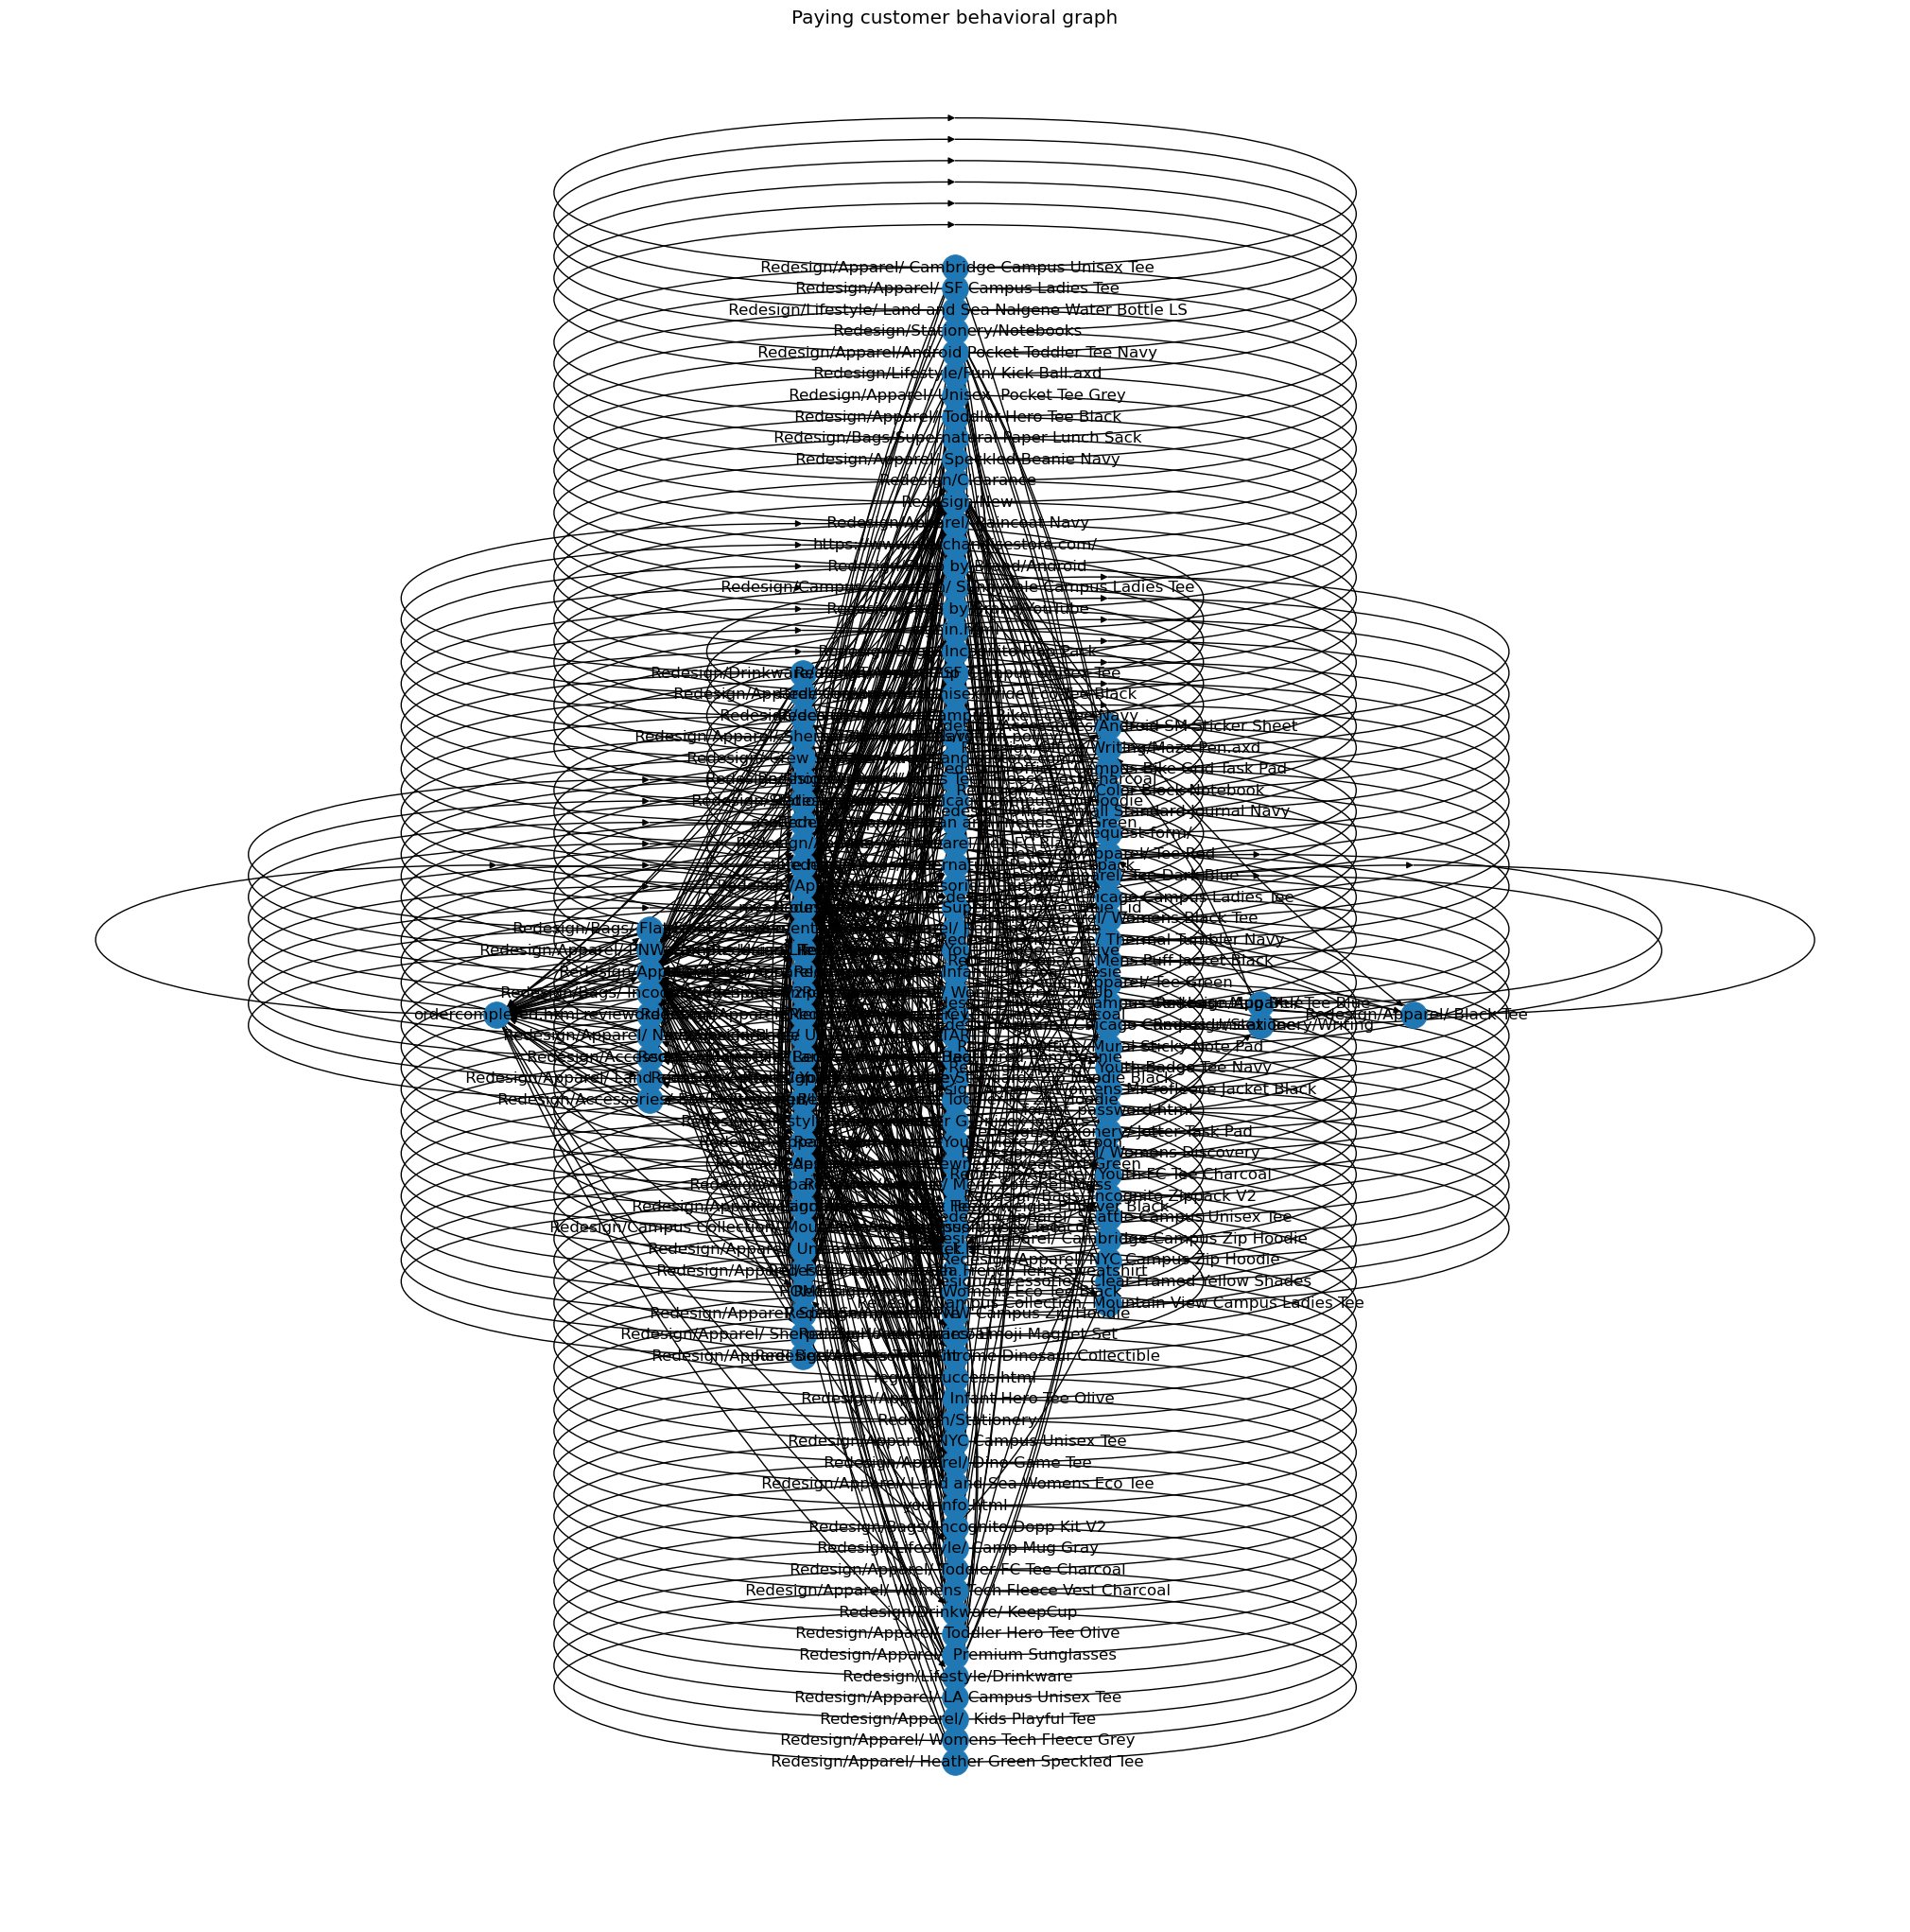

In [24]:
behavior_graph = nx.DiGraph()

behavior_graph.add_edges_from(paths)

for node_id in behavior_graph.nodes():
    behavior_graph.nodes[node_id]['depth'] = node_id.count('/')
    behavior_graph.nodes[node_id]['start_dist'] = nx.dijkstra_path_length(behavior_graph, source=node_id, target="ordercompleted.html")

plt.figure(figsize=(20, 20))
pos = nx.multipartite_layout(behavior_graph, subset_key='start_dist')  # Force-directed layout

nx.draw(
    behavior_graph, 
    pos, 
    with_labels=True,
    node_size=400,
    arrows=True,
    connectionstyle="arc3,rad=0.1",  # Smaller radius for self-loops
)
    
plt.title("Paying customer behavioral graph")
plt.axis('off')
plt.show()


> as we can see this is too deep and unreadable
> 
> let's do some pruning and try
> 
> starting with no cycles

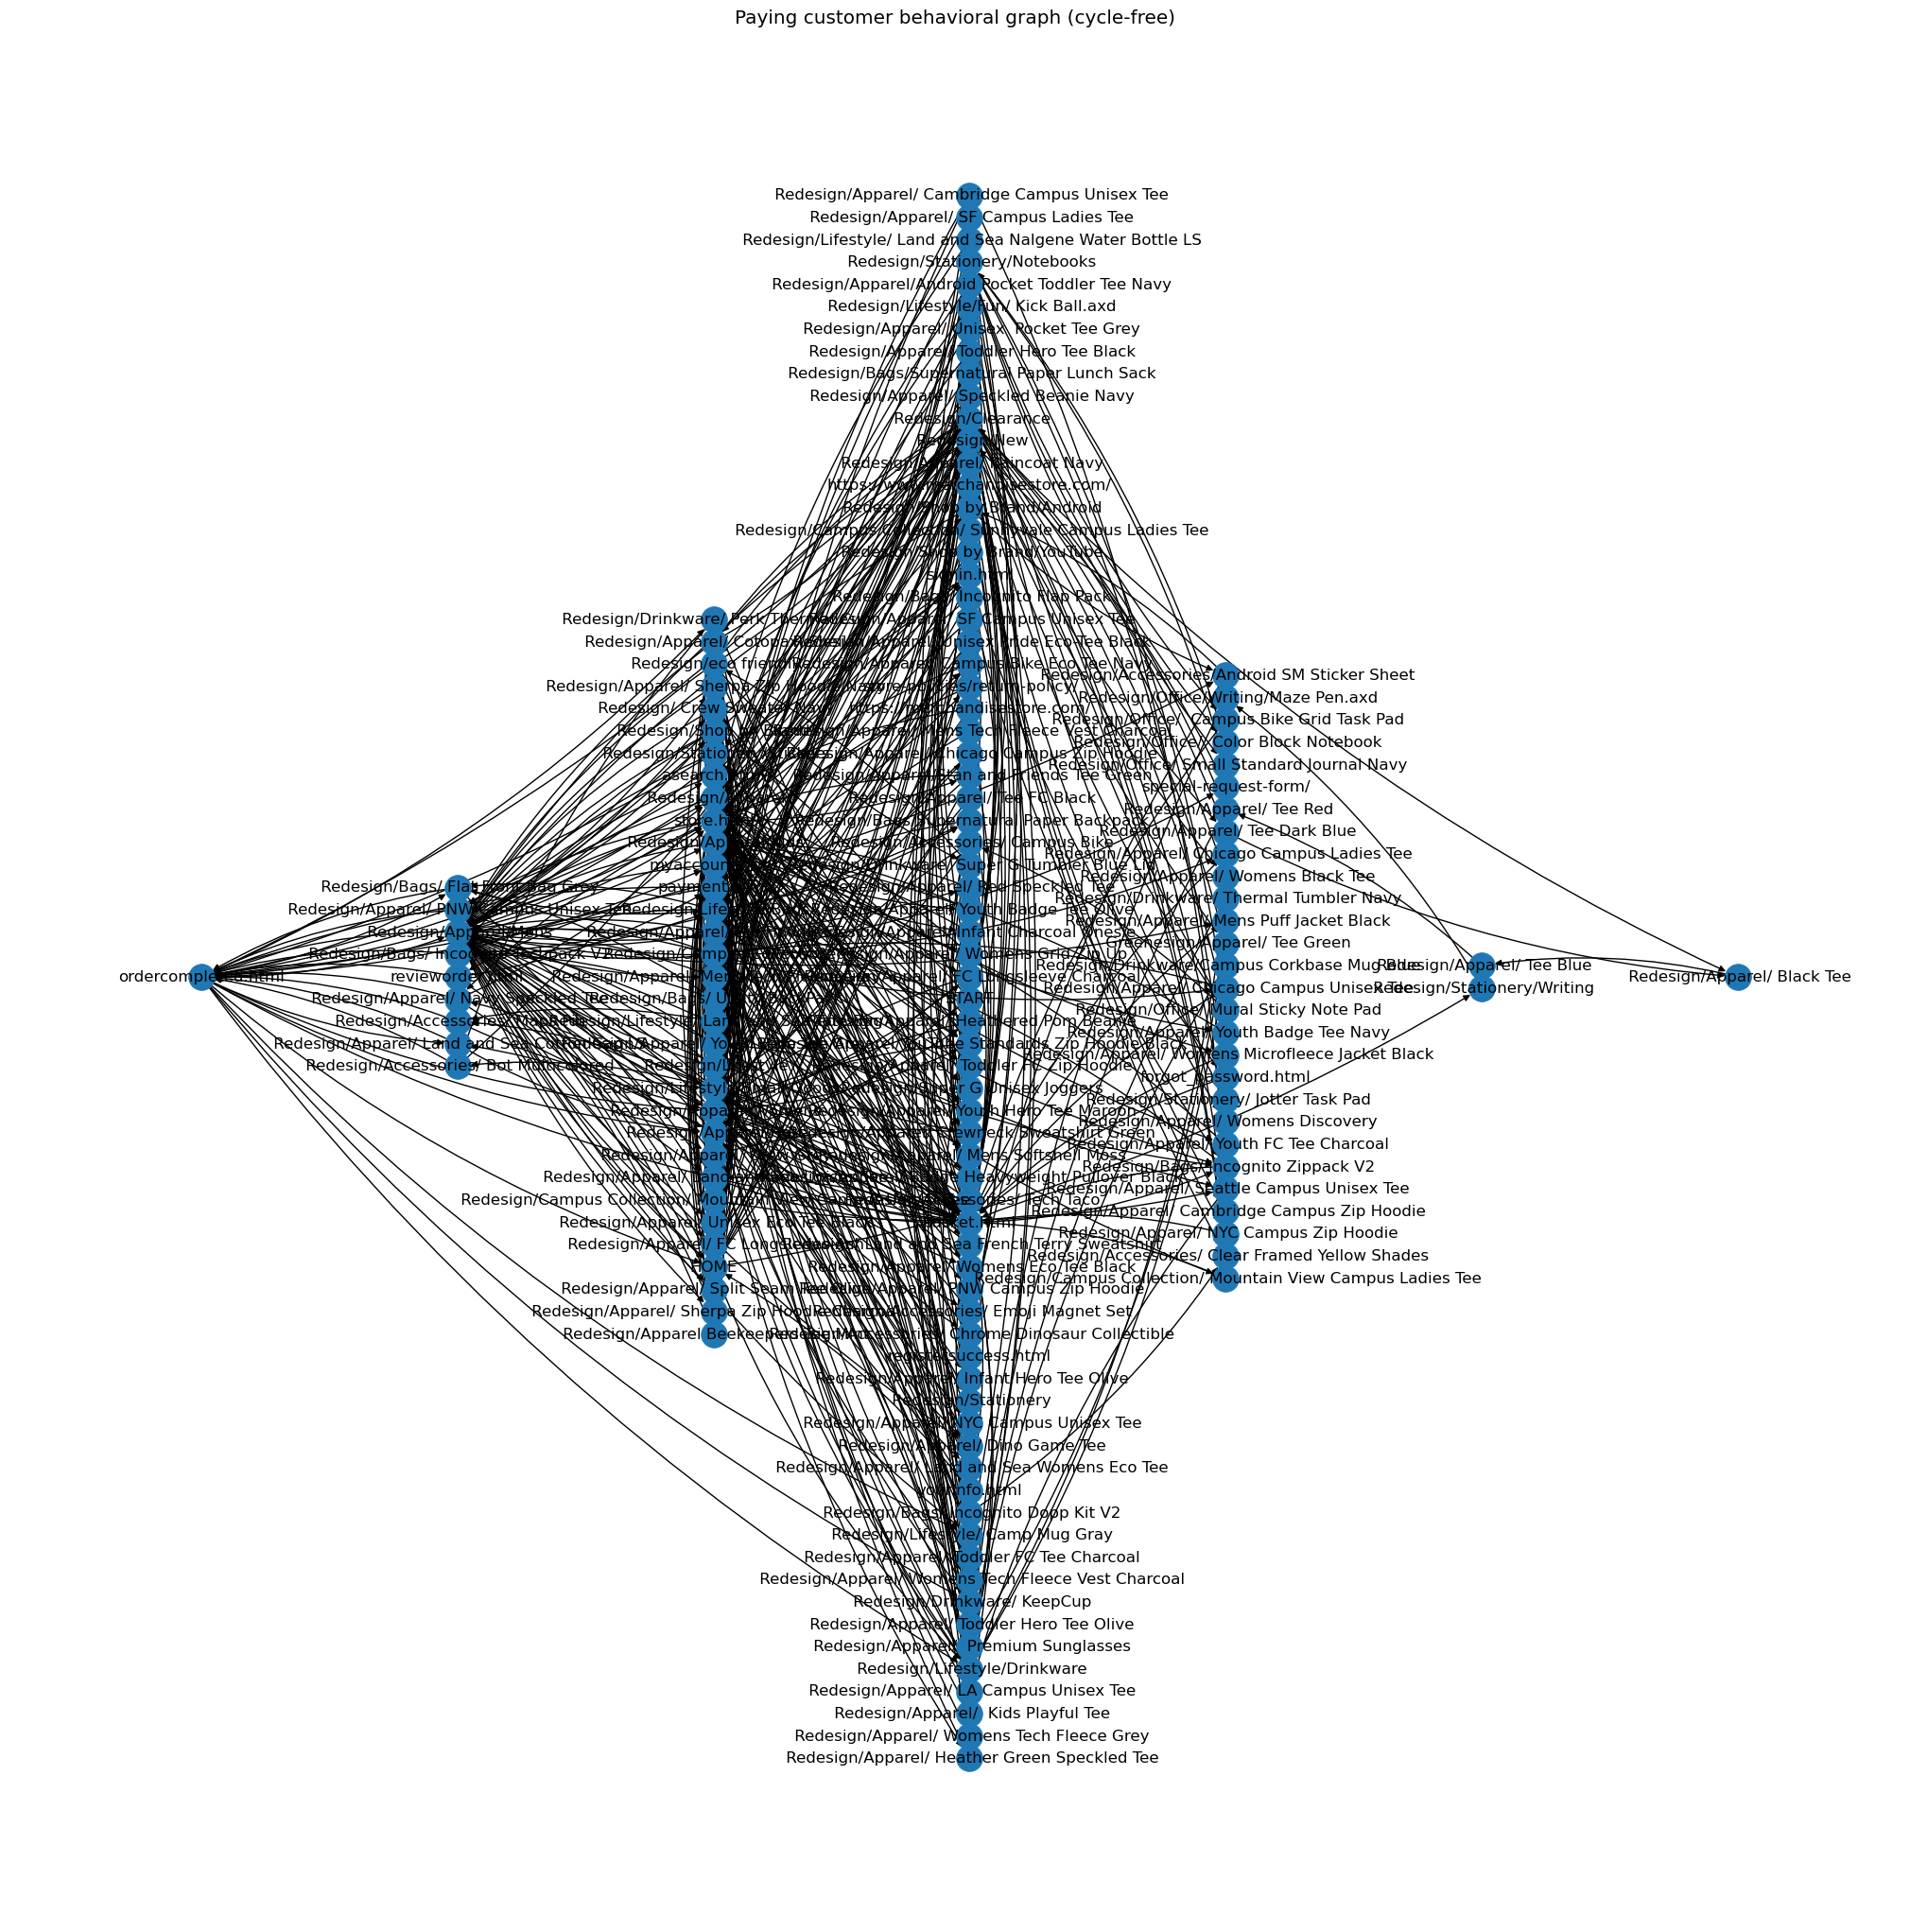

In [25]:
# we omit circular traffic to not complicate graph further
behavior_graph.remove_edges_from(nx.selfloop_edges(behavior_graph.copy()))

plt.figure(figsize=(20, 20))
pos = nx.multipartite_layout(behavior_graph, subset_key='start_dist')  # Force-directed layout

nx.draw(
    behavior_graph, 
    pos, 
    with_labels=True,
    node_size=400,
    arrows=True,
    connectionstyle="arc3,rad=0.1",  # Smaller radius for self-loops
)
    
plt.title("Paying customer behavioral graph (cycle-free)")
plt.axis('off')
plt.show()

> already better but still too dense
>
> let's try pruning small-weight edges

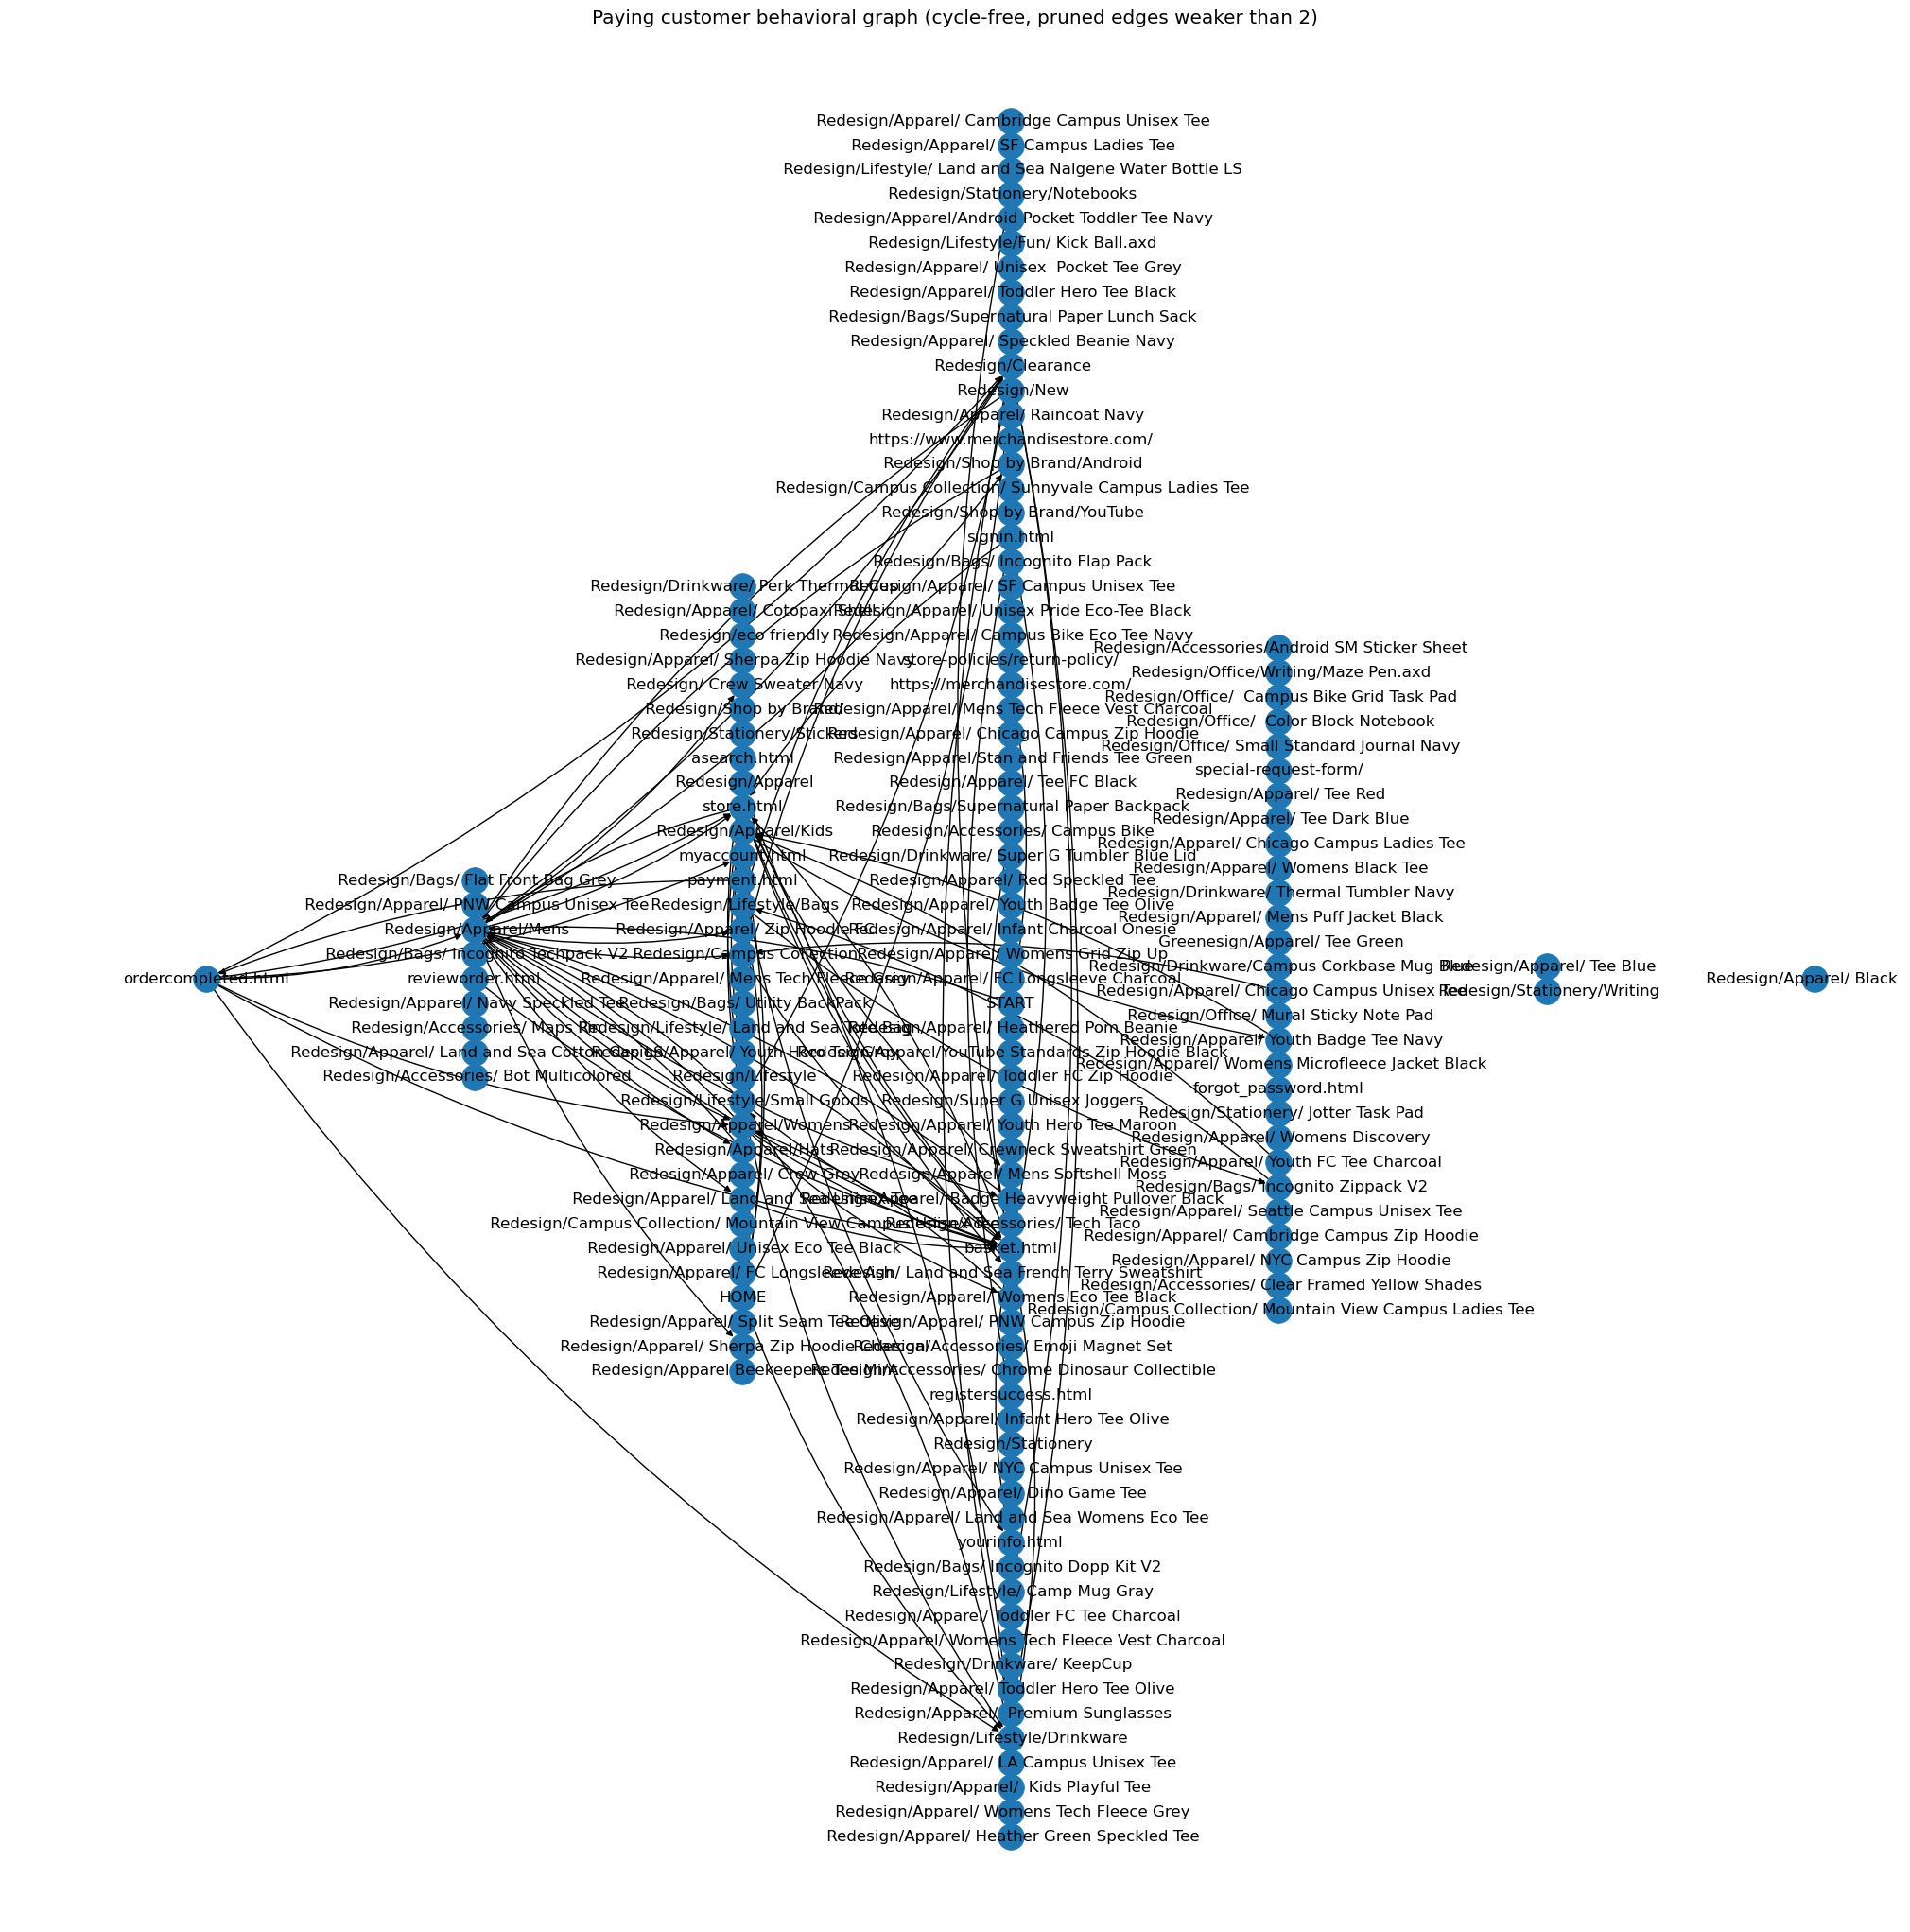

In [26]:
min_weight = 2

weak_edges = [(u, v) for u, v, d in behavior_graph.edges(data=True) 
                      if d.get('weight', 1) < min_weight]

behavior_graph.remove_edges_from(weak_edges)

plt.figure(figsize=(20, 20))
pos = nx.multipartite_layout(behavior_graph, subset_key='start_dist')  # Force-directed layout

nx.draw(
    behavior_graph, 
    pos, 
    with_labels=True,
    node_size=400,
    arrows=True,
    connectionstyle="arc3,rad=0.1",  # Smaller radius for self-loops
)
    
plt.title(f"Paying customer behavioral graph (cycle-free, pruned edges weaker than {min_weight})")
plt.axis('off')
plt.show()

> looking better but let's remove the unconnected nodes

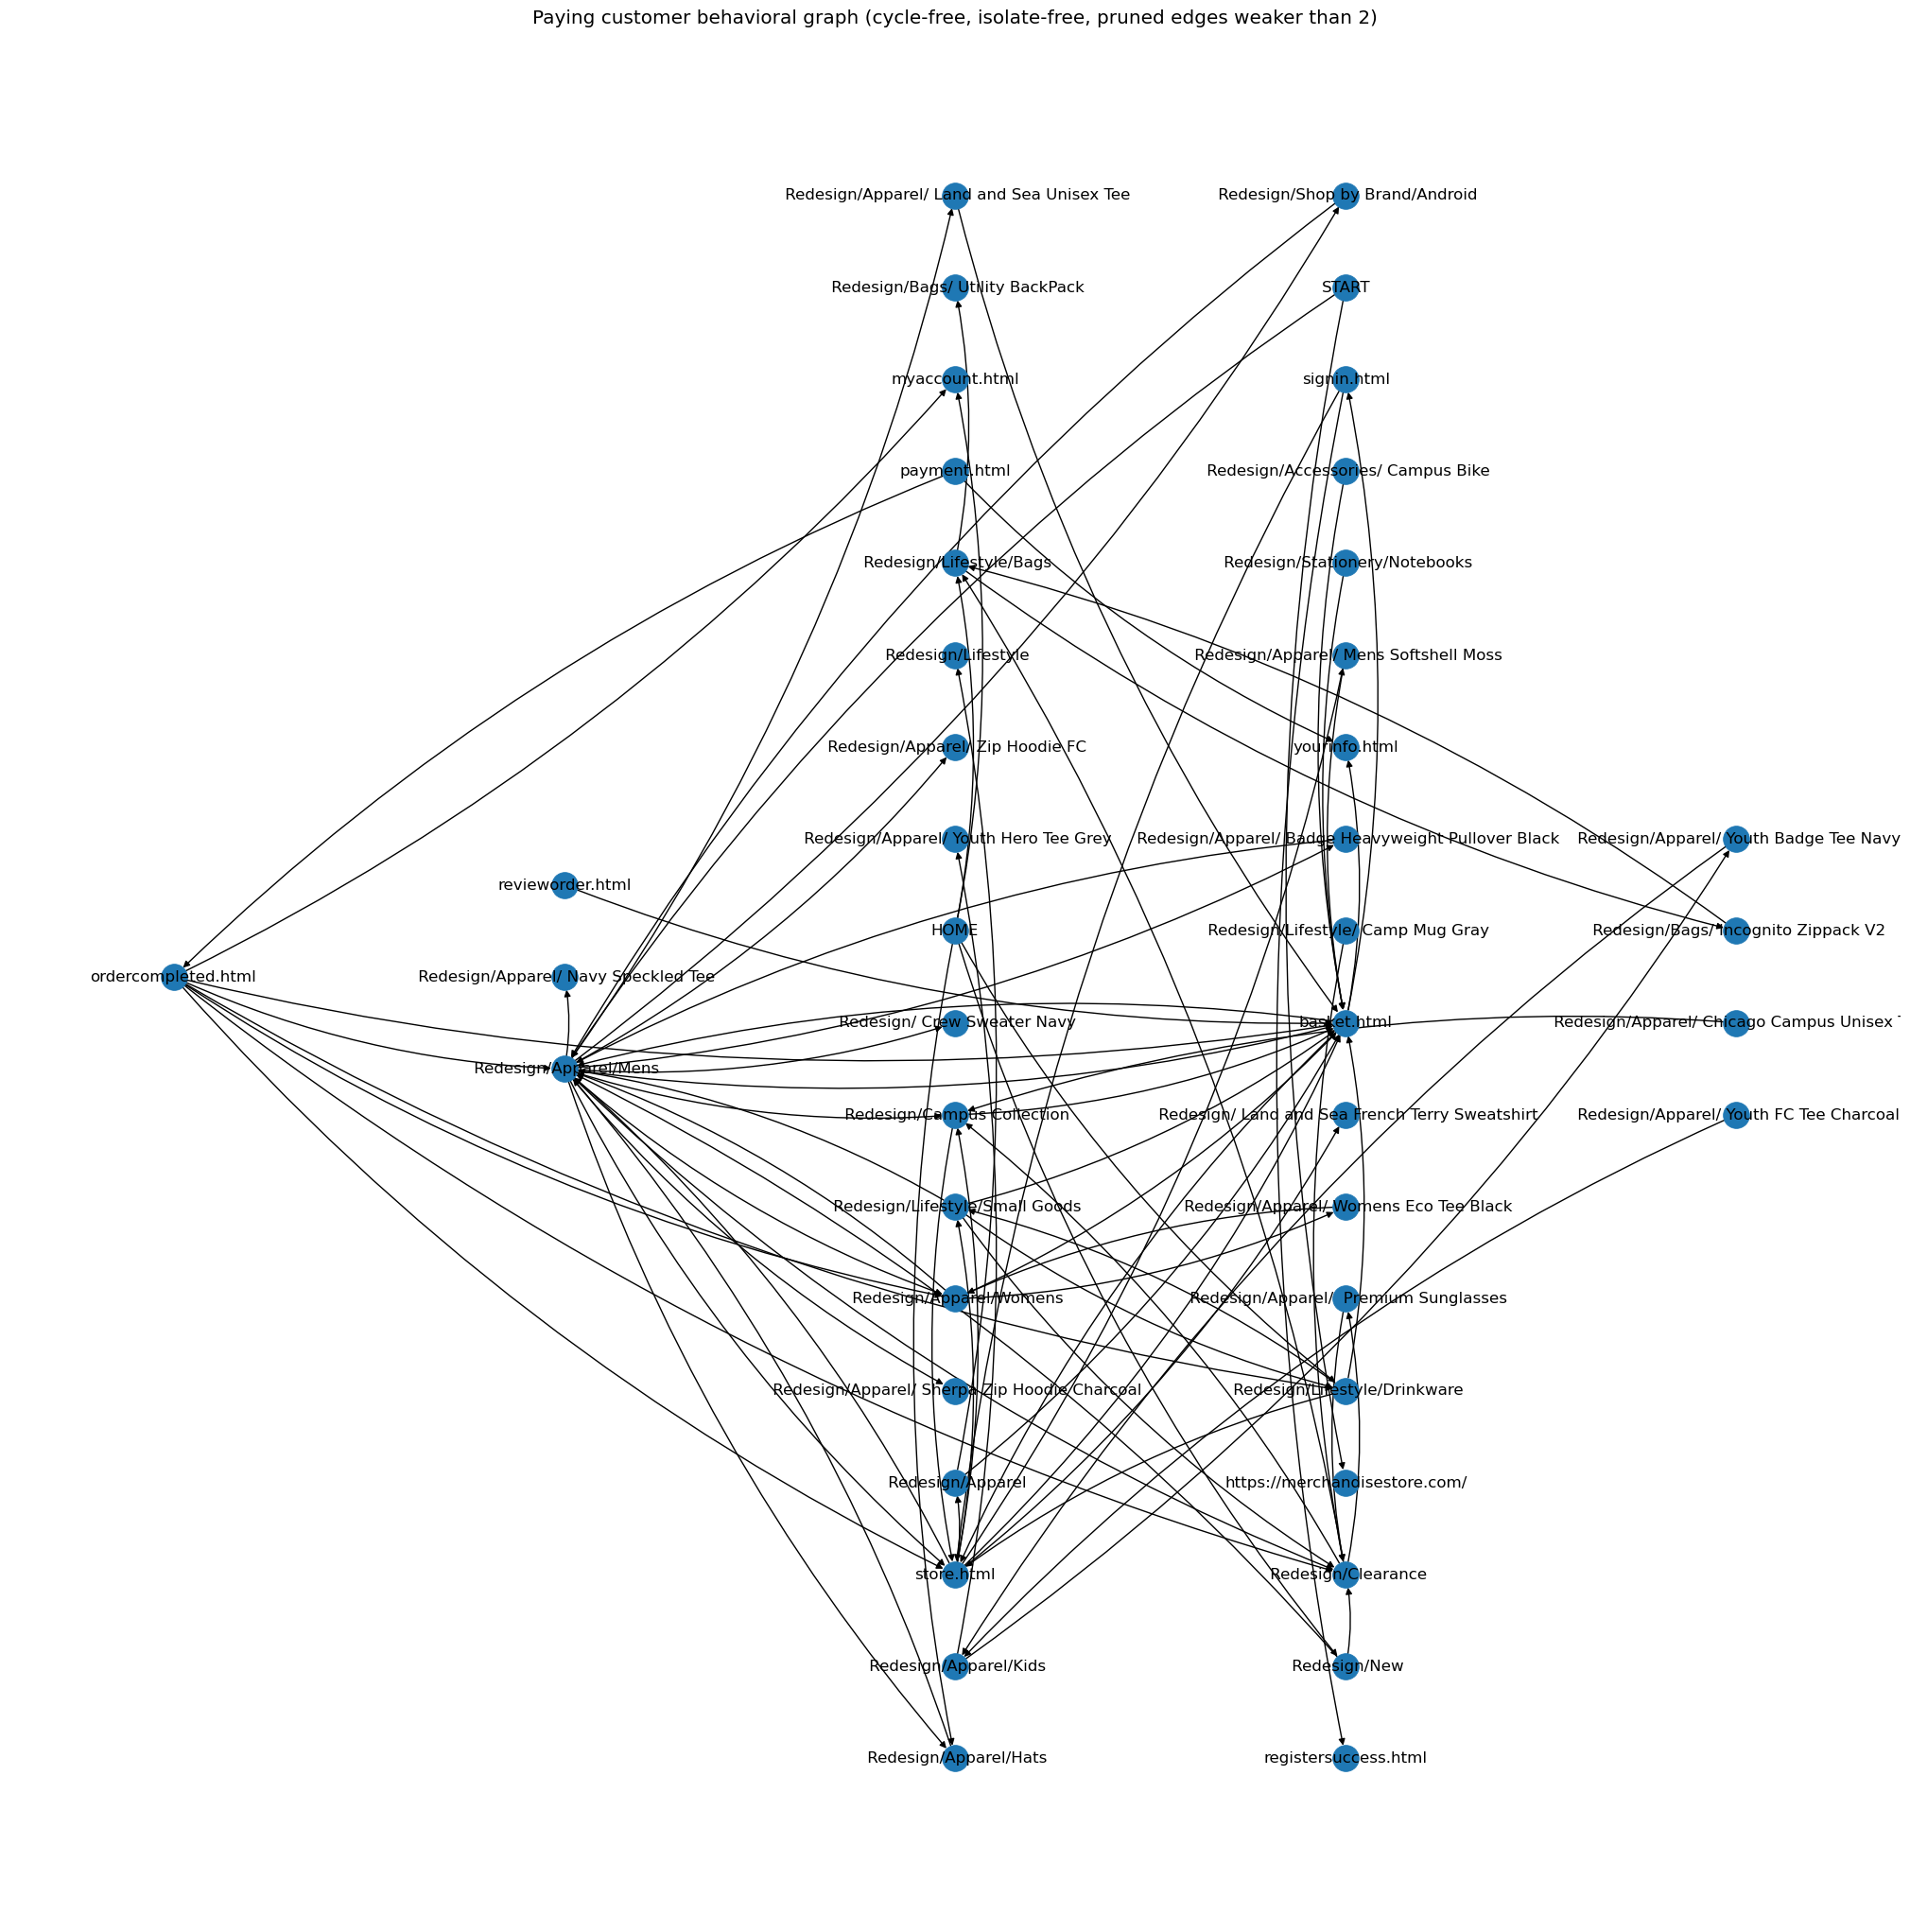

In [27]:
min_weight = 2

isolated_nodes = list(nx.isolates(behavior_graph))

behavior_graph.remove_nodes_from(isolated_nodes)

plt.figure(figsize=(20, 20))
pos = nx.multipartite_layout(behavior_graph, subset_key='start_dist')  # Force-directed layout

nx.draw(
    behavior_graph, 
    pos, 
    with_labels=True,
    node_size=400,
    arrows=True,
    connectionstyle="arc3,rad=0.1",  # Smaller radius for self-loops
)
    
plt.title(f"Paying customer behavioral graph (cycle-free, isolate-free, pruned edges weaker than {min_weight})")
plt.axis('off')
plt.show()

> and now we have a really good graph

[see on github](https://github.com/TypicalUsername-ai/customer-behavior/blob/main/customer_behavior.ipynb)